# Lindbladian calculation of cavity dephasing time 💣

In [28]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tools import proj, params
import csv
from multiprocessing import Pool
from itertools import product
plt.style.use('ggplot')
import IPython
from IPython.core.display import display, HTML
%matplotlib inline
def I(x): return qt.qeye(x)

## 👉 What is the Lindblad master equation?
Normally, we evaluate the time evolution of a quantum system with the *Schrodinger equation*. Unfortunately, although it is *possible* to describe everything with the schrodinger equation, it is not always feasible to do so. Take, for example, interaction with the environment outside our experiment, we could model this interaction with the schrodinger equation but to do so we need to be able to model the quantum behaviour of the environment, and that is hard to impossible. A better approach is to use a *master equation* (the *Lindblad master equation*, to be precise), it allows usu to model the quantum dynamics of an open system, i.e. non-unitary operation on our quantum system. If we had, for example, a qubit that has some chance to collapse on the ground state every so often (non-coherently, that is) we could model such thing with the master equation.

This is the **Lindblad master equation** in it's full form:
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{n,m=1}^{N^2-1} h_{nm}(A_n \rho A^\dagger_m - \frac{1}{2}\{A^\dagger_mA_n, \rho\})$$
But is better solved (for us) with it's diagonal form
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{i=1}^{N^2-1} \gamma_i(L_i \rho L^\dagger_i - \frac{1}{2}\{L^\dagger_i L_i, \rho\})$$
Where $\gamma_i$ is the rate at which this process occurs and $L_i$ are the *Lindblad operators* (or *jump operators*),
$$L_i = \sum_{j=1}^{N^2-1}u_{ji}A_j$$
$u$ is the unitary transformation that diagnelizes $h$, i.e. $u^\dagger h u$ is a diagonal matrix.

You can approximate this expression to make it simpler using the Born, Markov, and Secular approximations, and get
$$L_A[\rho]=2A O A^\dagger - A^\dagger A O - O A^\dagger A$$
$$\dot{\rho} = - \frac{i}{\hbar}[H, \rho] + \sum_A \frac{\gamma_A}{2}L_A[\rho]$$
Where each A is a non-unitary operator (Q: could it be unitary?) that happens with rate $\gamma$

#### 🔹 Defining parameters

In [29]:
# params = {}
# with open('parameters.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for row in csv_reader:
#         params[row[0]] = float(row[1])

In [43]:
wc       = 0*2*np.pi*0.5e-2   # cavity frequency
# wc=2*np.pi
wa       = 0             # atom frequency
g        = 2*np.pi*0.2   # coupling strength
chi_e    = 2*np.pi*0.05
chi_f    = 2*np.pi*0.1
kappa    = 1e-6          # cavity dissipation rate
gamma    = 0.01          # atom dissipation rate
N        = 5             # number of cavity fock states
qub_lvls = 3
n_th_a   = 0.02          # avg number of atom bath excitation
n_th_c   = 0.01          # avg number of cavity bath excitation
mu       = [1e-3, 1e-3]  # Measurement error rate
# tlist  = params.tlist
tlist = np.linspace(0, 1_000_000, 10_000)  # MUST: max(tlist) >> 1/chi

#### 🔹 Defining Hamiltonian, initial state and operators

In [44]:
# intial state
cav0  = (qt.basis(N, 1) + qt.basis(N, 0))/np.sqrt(2)
qub0  = qt.basis(qub_lvls, 0)
# psi0  = qt.ket2dm(qt.tensor(cav0, qub0))
psi0  = qt.ket2dm(qt.tensor(cav0, qub0))
psi_e = qt.ket2dm(qt.tensor(cav0, qt.basis(qub_lvls, 1)))

cav1  = (qt.basis(N, 0) - qt.basis(N, 1))/np.sqrt(2)  # |0>-|1>

psi1  = qt.ket2dm(qt.tensor(cav1, qub0))              # |0>-|1> X |g>
psi_1 = qt.ket2dm(qt.tensor(cav1, qt.basis(3,1)))     # |0>-|1> X |e>

# operators
a   = qt.tensor(qt.destroy(N), qt.qeye(qub_lvls))
ad  = a.dag()
sm  = qt.tensor(qt.qeye(N), qt.destroy(qub_lvls))
smd = sm.dag()

# Hamiltonian (no RWA) jayness cummings
# chi_e*|e><e| + chi_f*|f><f| chi_f ~ 2*chi_e
e = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 1))
ed = e.dag()
f = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 2))
fd = f.dag()

H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd )  # Wc ad*a + Wa |e><e| + ad*a * (chi_e |e><e| + chi_f |f><f|)

#### 🔹 Defining collapse operators
Now this is the interesting part. Each operators in the list `c_ops` will be evaluated as if it's operation is occouring at some specified rate. So the third one, for example, the $\hat{\sigma}_z$ is responsible for qubit non-coherently relaxing.

In this test, these are the collapse operators:
  * **Cavity relaxation:** $\sqrt{K(1 + n_{th})} \hat{a}\ \rightarrow$               The cavity loses a photon due to thermal noise
  * **Cavity excitation:** $\sqrt{Kn_{th}} \hat{a}^\dagger \quad\quad\rightarrow$  The cavity gains a photon due to thermal noise
  * **Qubit relaxation:** $\sqrt{\gamma(1 + n_{th})} \hat{\sigma}_-\ \rightarrow$               The atom loses a photon due to thermal noise
  * **Qubit excitation:** $\sqrt{\gamma n_{th}} \hat{\sigma}_+ \quad\ \ \quad\rightarrow$  The atom gains a photon due to thermal noise
  * **Qubit relaxation:** $\sqrt{\gamma} \hat{\sigma}_-\quad\quad\quad\ \ \rightarrow$  The atom collapses to the ground state

In [45]:
c_ops = [
    np.sqrt(0.5*kappa*(1+n_th_c)) * a,     # cavity relaxation (Thermal)
    np.sqrt(0.5*kappa*n_th_c) * a.dag(),   # cavity excitation (Thermal)
    np.sqrt(0.5*gamma*(1+n_th_a)) * sm,    # qubit relaxation  (Thermal)
    np.sqrt(0.5*gamma*n_th_a) * sm.dag(),  # qubit excitation  (Thermal)
]

In [46]:
# Results. Heisenberg picture, project on photon number and "atom number"
e_ops = [psi0, psi1, sm.dag()*sm]

output = qt.mesolve(H, psi0, tlist, c_ops, e_ops, progress_bar=True)

10.0%. Run time:   2.03s. Est. time left: 00:00:00:18
20.0%. Run time:   4.06s. Est. time left: 00:00:00:16
30.0%. Run time:   6.09s. Est. time left: 00:00:00:14
40.0%. Run time:   8.11s. Est. time left: 00:00:00:12
50.0%. Run time:  10.14s. Est. time left: 00:00:00:10
60.0%. Run time:  12.17s. Est. time left: 00:00:00:08
70.0%. Run time:  14.19s. Est. time left: 00:00:00:06
80.0%. Run time:  16.22s. Est. time left: 00:00:00:04
90.0%. Run time:  18.25s. Est. time left: 00:00:00:02
Total run time:  20.28s


In [47]:
# d = {}
# for i, t in enumerate(tlist):
#     d[t] = output.expect[2][i]

In [48]:
# plt.plot([abs(np.trace(state*(psi0 + psi_e))) for state in output.states])

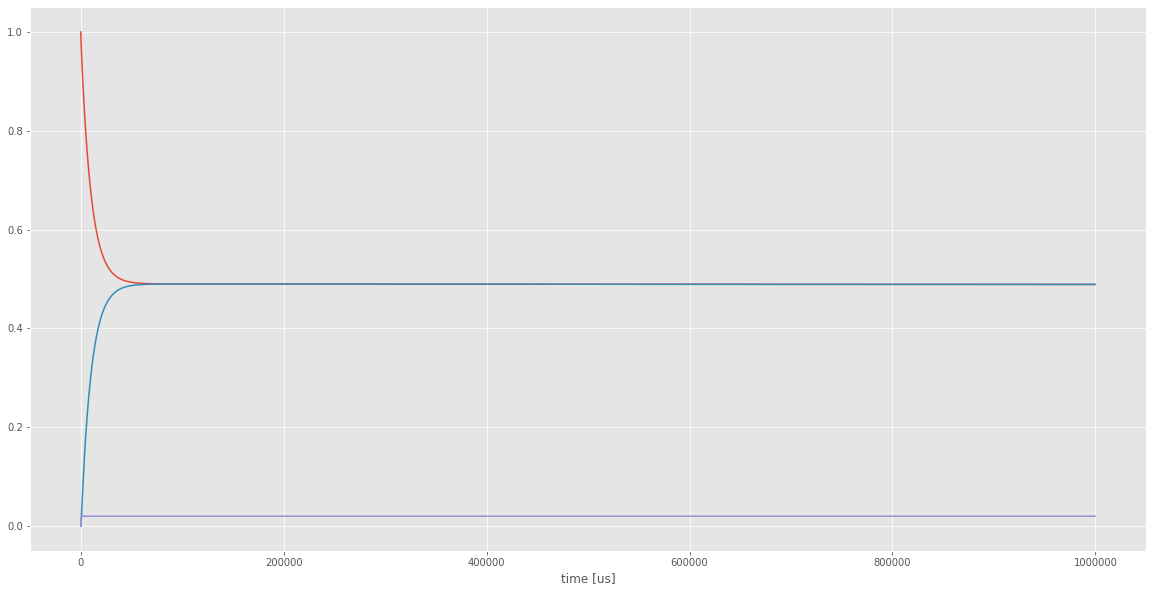

In [49]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlabel('time [us]')

ax.plot(tlist, output.expect[0])
ax.plot(tlist, output.expect[1])
ax.plot(tlist, output.expect[2]);

We can clearly see the dephasing by the decay of the curve. We want to minimize the dephasing so here's one approach.

Since the thermal excitations cause the problem, we want to remove them as much as possible. One way is to cool down the system more and more, but obviouly we would reach our limit pretty quickly.
A different approach would be to measure the qubit repeatedly, and if we measure it to be in the excited state, put it back into the ground state. We can do this by projecting the qubit-cavity state into this state:
$$\rho_{new} \leftarrow (I \otimes |g><g|)\ \rho_{old}\ (I\otimes|g><g|) + (I \otimes |e><e|)\ \rho_{old}\ (I \otimes |e><e|)$$
This comes from putting the qubit into the ground state, and adding the cavity state of the ground part (of the qubit, i.e. the cavity state if the qubit were grounded) together with the cavity state of the excited part, like so
$$\text{qubit} \otimes\text{cavity} \rightarrow \text{ground} \otimes (\text{cavity}_{ground} +  \text{cavity}_{ground})$$
Now let's put this into code

In [50]:
def sim_meas(psi0, H, dt):
    """Simulate the system and do a measurment each dt time step, each measurment project the qubit state to the ground state"""
    states = []
    for t in np.arange(0, len(tlist), dt):
        psi_meas   = proj(states[-1], N, mu) if states else psi0
        time_range = tlist[t:min(t+dt, len(tlist))]

        output = qt.mesolve(H, psi_meas, time_range, c_ops)
        states.extend(output.states)
    return states

In [92]:
states = sim_meas(psi0, H, len(tlist)+1)

# qstates = np.array([np.real(state.ptrace(1)) for state in states])

# n = [[abs(np.trace(state*(psi0 + psi_e))) for state in states],
#      [abs(np.trace(state*(psi1 + psi_1))) for state in states]]
n = [[abs(np.trace(state*(psi0))) for state in states]]

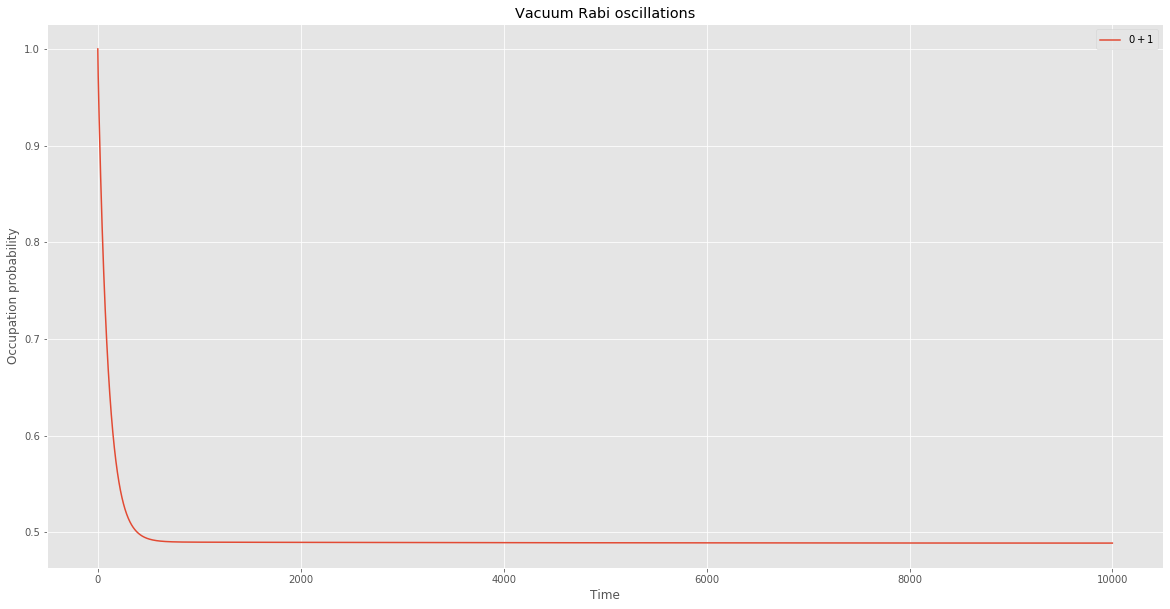

In [93]:
fig, ax = plt.subplots(figsize=(20,10))

# ax.plot(qstates[:,0,0])  # P(|e>)
ax.plot(n[0])            # P(|0>+|1> X |g> + |0>+|1> X |e>)
# ax.plot(n[1])            # P(|0>-|1> X |g> + |0>-|1> X |e>)

ax.legend(["$0+1$", "$0-1$", "atom"])
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Vacuum Rabi oscillations');
# ax.set_ylim(0, 1)
plt.show();

We can see that the decay rate is much smaller than it was eariler, thanks to what we did.

/home/dnl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


7926.539040439761 0.9978354240430101


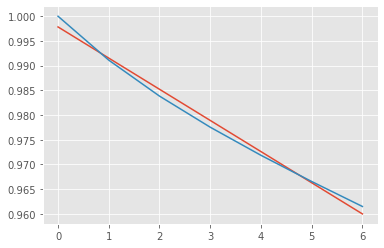

In [100]:
def sinexp(x, w, r, A, C, D):
    return A*(1+np.cos(w*x)+D)*np.exp(-x*r)+C
def exp(x, A, r, C):
    return A*np.exp(-r*x)+C
# popt, pcov = curve_fit(sinexp, tlist, n[0], maxfev=100000000, bounds=([0,0,0, -0.1, -1], [10,5,1.2, 1.1,1]), p0=[chi_e, gamma, 1, 0,0.5])
popt, pcov = curve_fit(exp, tlist, n[0], bounds=([-5,-5,-2], [5, 5, 2]), p0=[1, 0.1, 0.5])

cut = 7
m, b = np.polyfit(tlist[:cut], n[0][:cut], 1)
plt.plot(m*tlist[:cut] + b)
plt.plot(n[0][:cut])
print(-.5/m, b)


▶️ amplitude  = 0.501
▶️ decay-rate = 0.000
▶️ Const      = 0.489



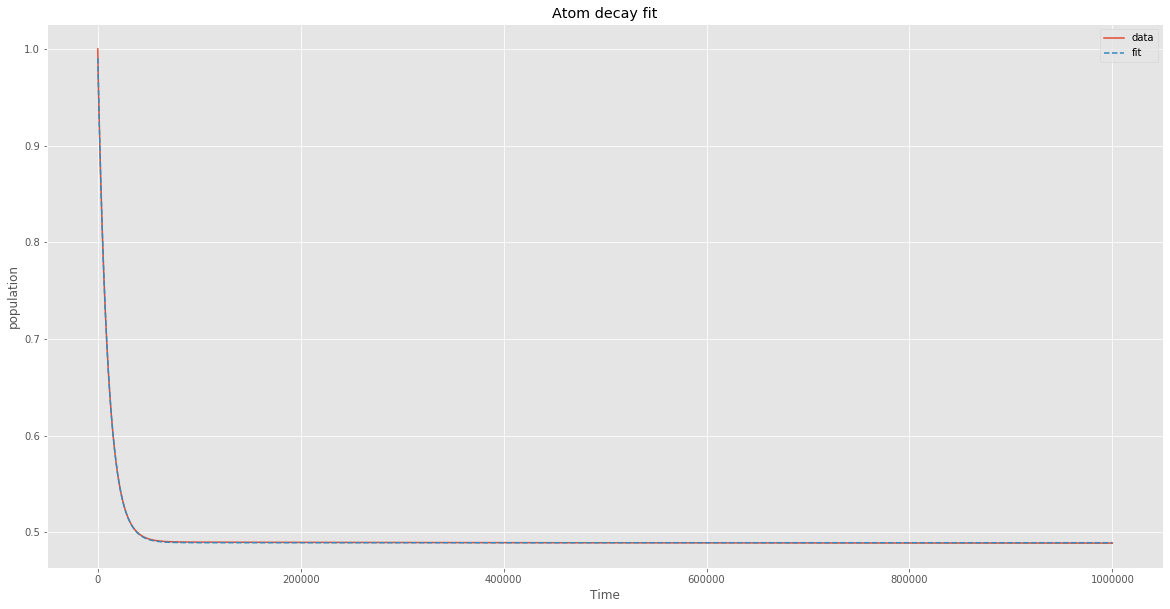

In [95]:
fit = exp(tlist, *popt)
# fit = sinexp(tlist, *popt)
plt.figure(figsize=(20,10))

# plt.plot(tlist, popt[2]*(2+popt[4])*np.exp(-tlist*popt[1])+popt[3], '--',
#          tlist, popt[2]*(popt[4])*np.exp(-tlist*popt[1])+popt[3], '--', color='black')
# plt.fill_between(tlist, popt[2]*(2+popt[4])*np.exp(-tlist*popt[1])+popt[3],
#                  popt[2]*(popt[4])*np.exp(-tlist*popt[1])+popt[3], color='black', alpha=0.05)

plt.plot(tlist, n[0], label='data')
plt.plot(tlist, fit, '--', label='fit')


plt.legend()
plt.title('Atom decay fit')
plt.xlabel('Time')
plt.ylabel('population')
# plt.ylim(0,1)

# print(
# """
# ▶️ Frequency  = {:.3f}
# ▶️ decay-rate = {:.3f}
# ▶️ amplitude  = {:.3f}
# ▶️ Const      = {:.3f}
# ▶️ Center     = {:.3f}
# """.format(*popt)
# )
print(
"""
▶️ amplitude  = {:.3f}
▶️ decay-rate = {:.3f}
▶️ Const      = {:.3f}
""".format(*popt)
)

🔹 Why the slight mismatch? Who knows 😞 Probably something with the fit function definition

In [101]:
print(f'The mean life-time of the qubit is\33[1m {1/popt[1]:.2f}\33[0m [Time units] (half-time={np.log(2)/popt[1]:0.2f})')

The mean life-time of the qubit is 10012.34 [Time units] (half-time=6940.03)


In [16]:
# plt.figure(figsize=(20,10))
# y = n[0]
# f = np.fft.fft(y)
# plt.plot(np.real(f)[10:])

### What's going on?
In this example, the transmon starts at the ground state, while the cavity starts at the superpositon $|0> + |1>$, since we give the cavity energy, the phase of the $|1>$ changes and the cavity state "rotates" from $|0> + |1>$ to $|0> - |1>$ and so forth. While we can easily see the oscilations, it is not so clear why would the cavity decay, after all, we set the cavity dissipation to be 0, it shouldn't have losses, so what's going on? Finally, we get to the real problem with **dephasing**. The reason the cavity oscilation decay is that we loose our knowladge of the frequency of the cavity, and if we don't know the frequency, we can't know after a while weather the cavity is in the state $|0> + |1>$ or $|0> - |1>$, so eventally it becomes a constant 50/50% of either state (i.e. the cavity approaches the state $\frac{1}{2}(|0>+|1>)(<0|+<1|) + \frac{1}{2}(|0>-|1>)(<0|-<1|)$).

But why do we loose our knowledge of the cavity frequency? Well, even though the cavity and the transmon are off resonance (so there aren't rabi oscilations between them) they are still coupled. Under the dissipative approximation, we can think of it as if **the state of the transmon affects the frequency of the cavity**, so if for example the cavity frequency is $\omega$ when the qubit is at the ground level, it would be $\omega + \chi$ when the transom is excited. And the transmon get's excited due to thermal fluctuation, so the frequency of the cavity changes and we get the dephasing.

In [17]:
# states = sim_meas(psi0, dt)
# n = [abs(np.trace(state*(psi0 + psi_e))) for state in states]
# plt.plot(n)

### The effect of the time between measurments on the dephasing rate
We can plot the dephasing rate (and the life-time) of the cavity vs the time between measurments ($dt$) and we see an interesting behivour. We can see that the life-time approachas infinity when $dt << \chi$.

In [18]:
# plt.figure(figsize=(10,5))
def func(tup):
    dt, chi_e = tup
    H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd)
    states = sim_meas(psi0, H, dt)
    n = [abs(np.trace(state*(psi0 + psi_e))) for state in states]
    popt, pcov = curve_fit(exp, tlist, n, maxfev=100000000, bounds=([-2,0,-1], [2, 5, 1]), p0=[-1, gamma, 1])
#     plt.figure()
#     plt.plot(n)
#     plt.plot(exp(tlist, *popt))
#     popt, pcov = curve_fit(exp, tlist, n[0], bounds=([-5,-5,-2, -5], [5, 5, 2, 5]), p0=[1, 2, 0.5, 0])
    return popt[1]

In [19]:
t_max = len(tlist)//10
pnts = min(20, t_max)
chi_pnts = 20

# decay_rate = np.ndarray([pnts, chi_pnts])
dt_list    = np.linspace(2, t_max, pnts, dtype=int)
chi_e_list = np.linspace(0, 1.5, chi_pnts)

param_range = list(product(dt_list,chi_e_list))

with Pool(20) as p:
    results = p.map(func, param_range)
# print(t_max)
# func(param_range[-1])

In [20]:
decay_rate = np.reshape(results, (pnts, chi_pnts))

In [21]:
# t_max = len(tlist)//10
# pnts = min(5, t_max)
# chi_pnts = 5

# decay_rate = np.ndarray([pnts, chi_pnts])
# for i, dt in enumerate(np.linspace(5, t_max, pnts, dtype=int)):
#     for j, chi_e in enumerate(np.linspace(0, 1.5, chi_pnts)):
#         H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd )
#         states = sim_meas(psi0, H, dt)
#         n = [abs(np.trace(state*(psi0 + psi_e))) for state in states]
#         plt.figure(figsize=(10,5))
#         plt.plot(n)
# #         popt, pcov = curve_fit(exp, tlist, n, maxfev=100000000, bounds=([-2,0,-1], [2, 5, 1]), p0=[-1, gamma, 1])
#         popt, pcov = curve_fit(exp, tlist, n[0], bounds=([-5,-5,-2, -5], [5, 5, 2, 5]), p0=[1, 2, 0.5, 0])

#         decay_rate[i, j] = popt[1]
#     print(f'{dt} | {100*(i+1)/pnts:.1f}%  -->  {popt[1]:.2e}    ', end='\r')

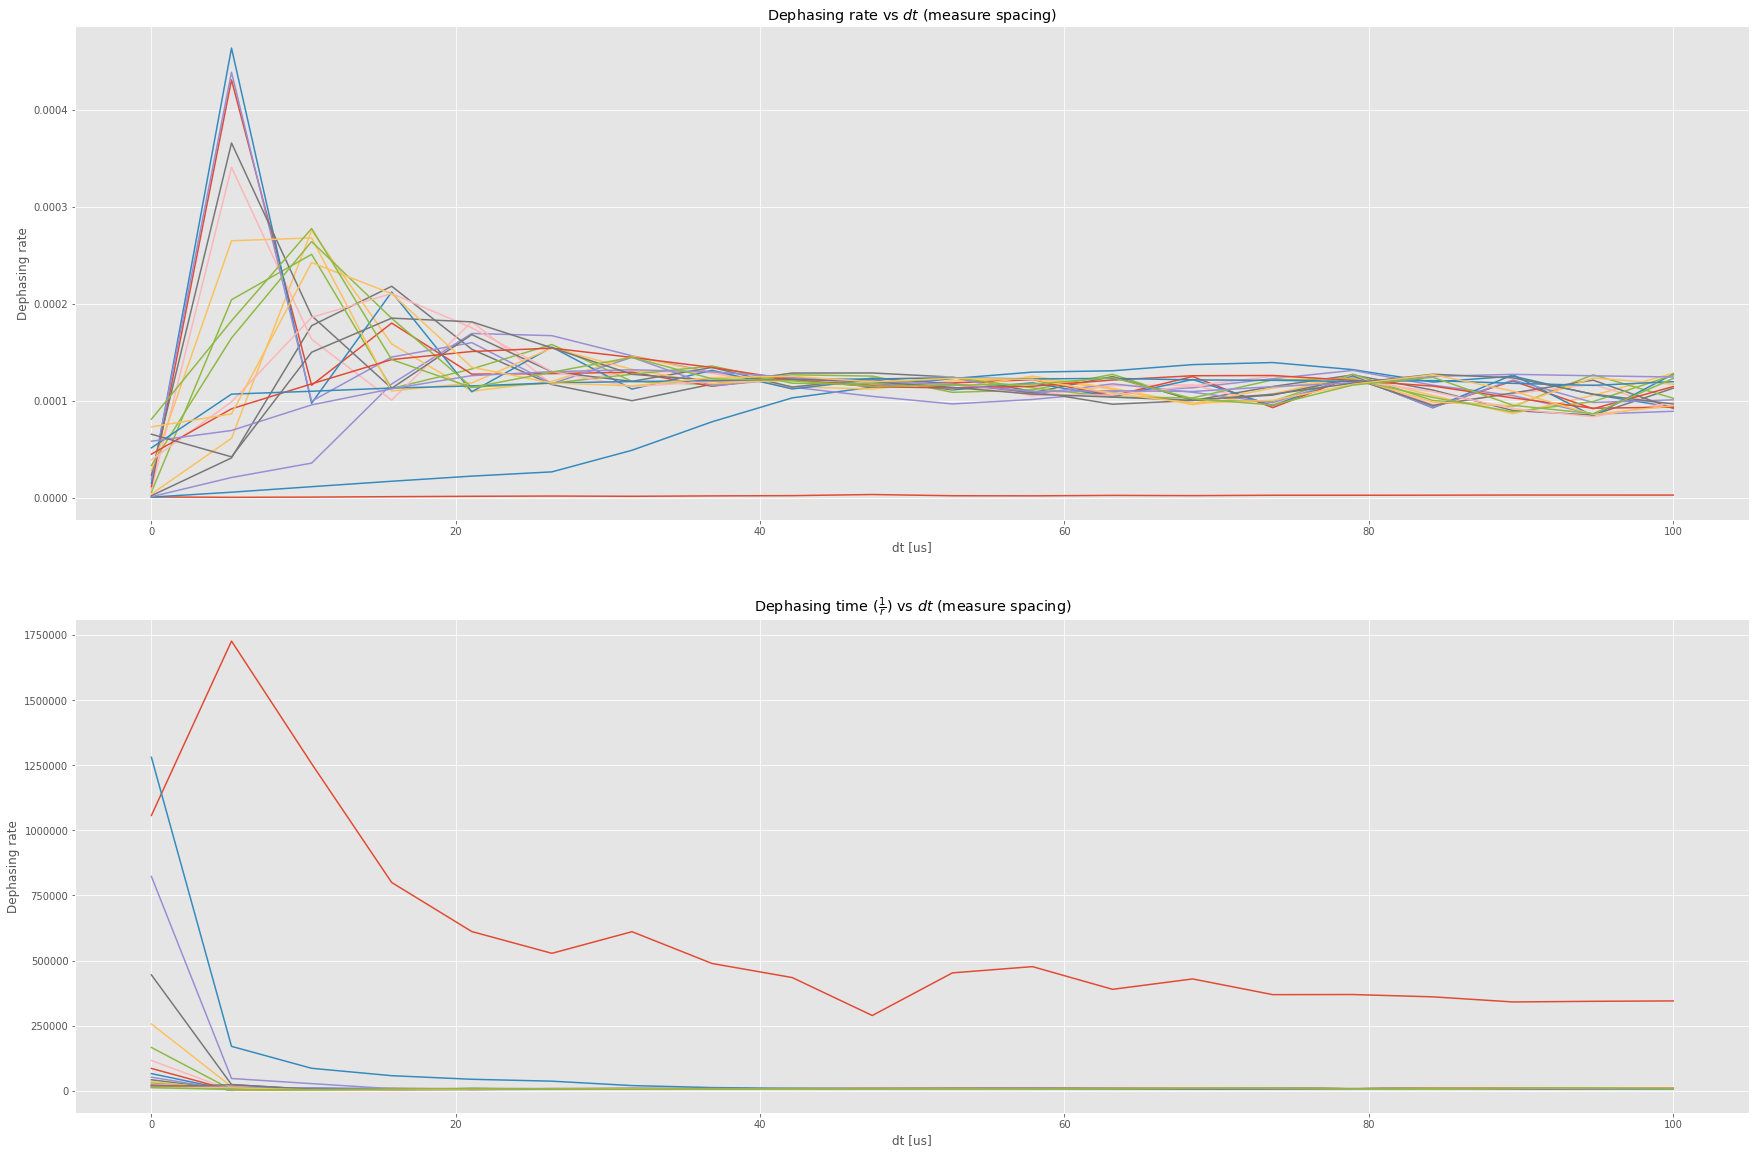

In [22]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(30, 20))
# --- Decay rate graphs ---
ax1.set_title('Dephasing rate vs $dt$ (measure spacing)')
ax1.set_xlabel(r'dt [us]')
ax1.set_ylabel('Dephasing rate')
# ax1.plot(np.linspace(tlist[0], tlist[t_max], len(decay_rate)), decay_rate, label='Decay rate')
ax1.plot(np.linspace(tlist[0], tlist[t_max], len(decay_rate)), decay_rate, label='Decay rate')
# ax1.axvline(1/chi_e, color='black', label=r'$\frac{1}{\chi_e}$')
# ax1.legend()

# --- Life time graphs ---
ax2.set_title(r'Dephasing time ($\frac{1}{r}$) vs $dt$ (measure spacing)')
ax2.set_xlabel(r'dt [us]')
ax2.set_ylabel('Dephasing rate')
ax2.plot(np.linspace(tlist[0], tlist[t_max], len(decay_rate)), 1/np.array(decay_rate), label='Life time')
# ax2.axvline(1/chi_e, color='black', label=r'$\frac{1}{\chi_e}$')
# ax2.legend()

plt.subplots_adjust(hspace=0.2)
plt.show()

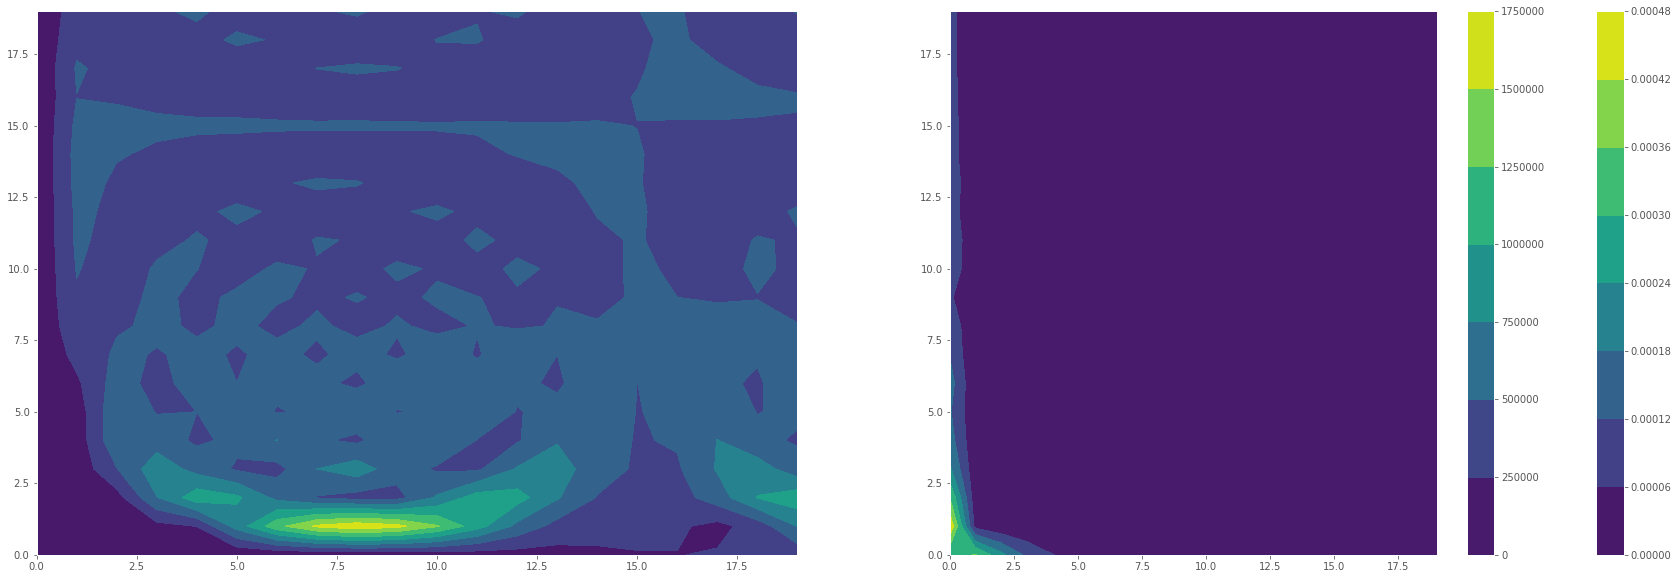

In [23]:
fig,(ax1, ax2)=plt.subplots(1,2, figsize=(30, 10))
cp1 = ax1.contourf(decay_rate)
cp2 = ax2.contourf(1/decay_rate)
fig.colorbar(cp1)
fig.colorbar(cp2)

* 

In [86]:
np.savetxt('decay_rate_high-res.csv', decay_rate, delimiter=',')

In [7]:
def A(j: int, k: int):
    return kappa*n_th_c*np.sqrt(j*k)
def B(j: int, k: int):
    return 1j*(k-j)*(wc+chi_e) - kappa*(n_th_c + 1/2)*(j+k) - kappa*n_th_a
def C(j: int, k: int):
    return kappa*(n_th_c+1)*np.sqrt((j+1)*(k+1))
def D(l):
    if l >= 0:
        j = 0
        k = l
    else:
        j = -l
        k = 0
    
    A_l = np.diag([A(i+j, i+k) for i in range(N-1 - abs(l))],-1)
    B_l = np.diag([B(i+j, i+k) for i in range(N - abs(l))])
    C_l = np.diag([C(i+j, i+k) for i in range(N-1 - abs(l))],1)
    return A_l + B_l + C_l

In [8]:
eigs = np.array([np.linalg.eig(D(l)) for l in range(-N+1, N)])
# eigvals = eigs[:, 0]
# eigvecs = eigs[:, 1]
eigvals = {}
eigvecs = {}
for l in range(-N+1, N):
    eigvals[l] = eigs[N+l-1, 0]
    eigvecs[l] = eigs[N+l-1, 1]

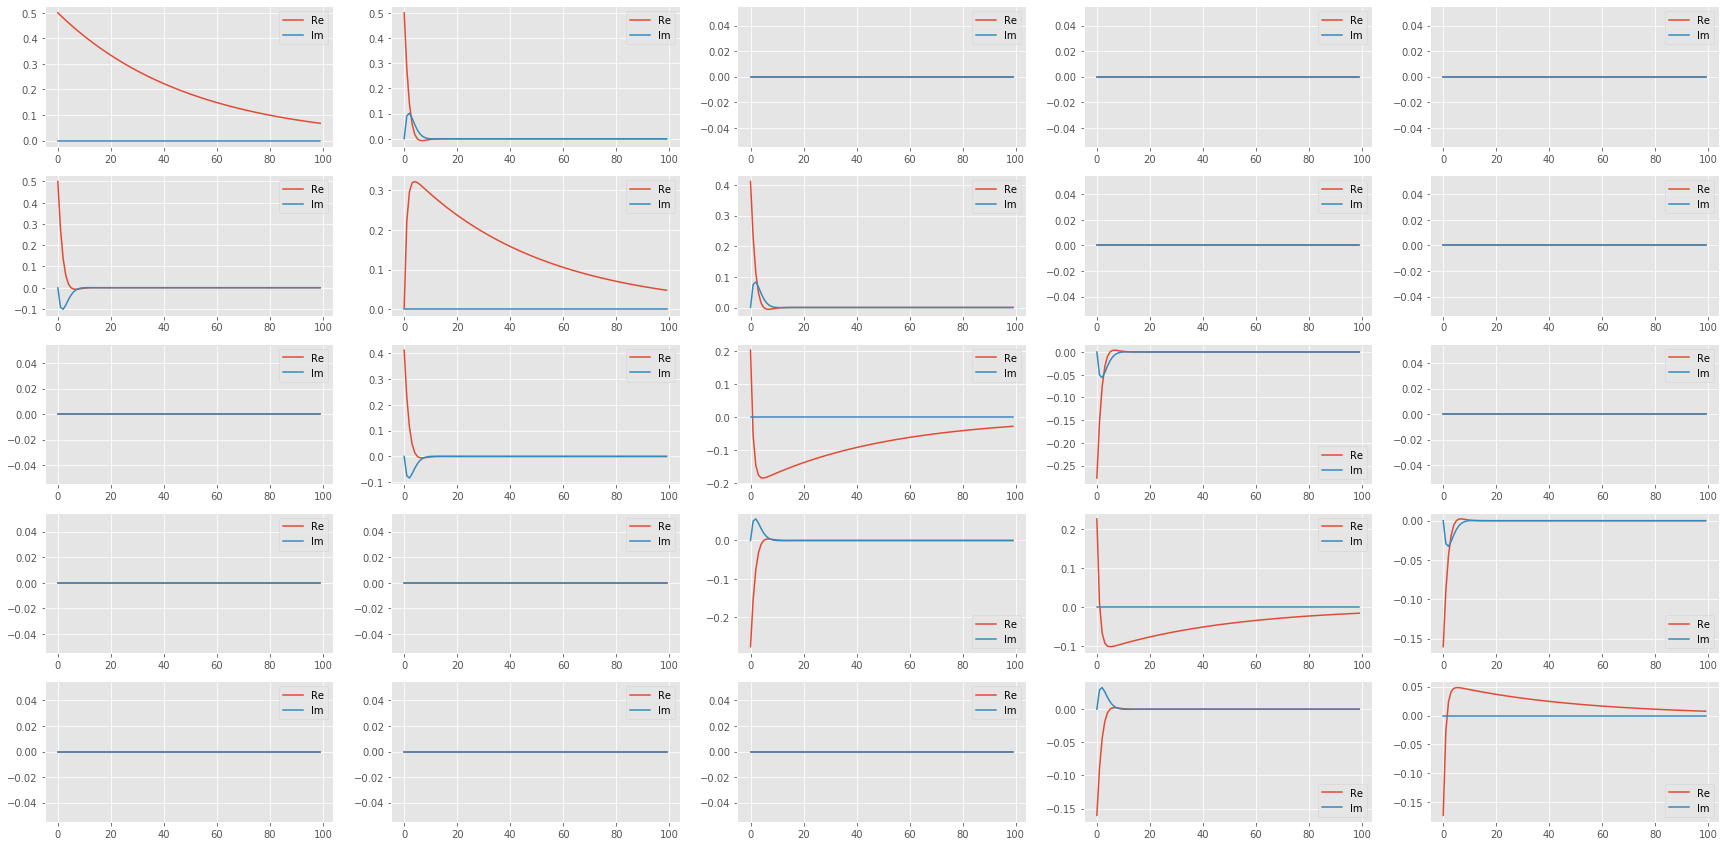

In [27]:
xp = 100
x = np.linspace(0,100000000,xp)

c0 = cav0*cav0.dag()  # Initial conditions

fig, axes = plt.subplots(N,N, figsize=(30,15))

for l in range(-N+1, N):
    s = 0
    i0 = 0 if l>=0 else -l
    j0 = 0 if l<=0 else l
    for i in range(N-abs(l)):
        # i, i+l
#         print(i0+i, j0+i)
        s += c0[i0+i, j0+i]*np.reshape(eigvecs[l][i], (1,N-abs(l)))*np.reshape(np.exp(eigvals[l][i]*x), (xp,1))

#     fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
#     ax1.plot(x, np.imag(s))
#     ax1.set_title(f'Im l={l}')
#     ax2.plot(x, np.real(s))
#     ax2.set_title(f'Re l={l}')
#     ax1.legend(['$c_{'+f'{i0+j}{j0+j}' '}$' for j in range(N-abs(l))])
#     axes[s]
    for i in range(N-abs(l)):
        ax = axes[i0+i, j0+i]
        ax.plot(np.real(s[:,i]))
        ax.plot(np.imag(s[:,i]))
        ax.legend(['Re', 'Im'])
        
#     print([f'{i0+i}{j0+i}' for i in range(N-abs(l))])

#     plt.ylim(-2,2);

In [13]:
decays = np.array([np.real(eig) for eig in eigs[:,0]])
freqs  = np.array([np.imag(eig) for eig in eigs[:,0]])

### Interesting - The average decay rate is equal for all diagonals 🤔

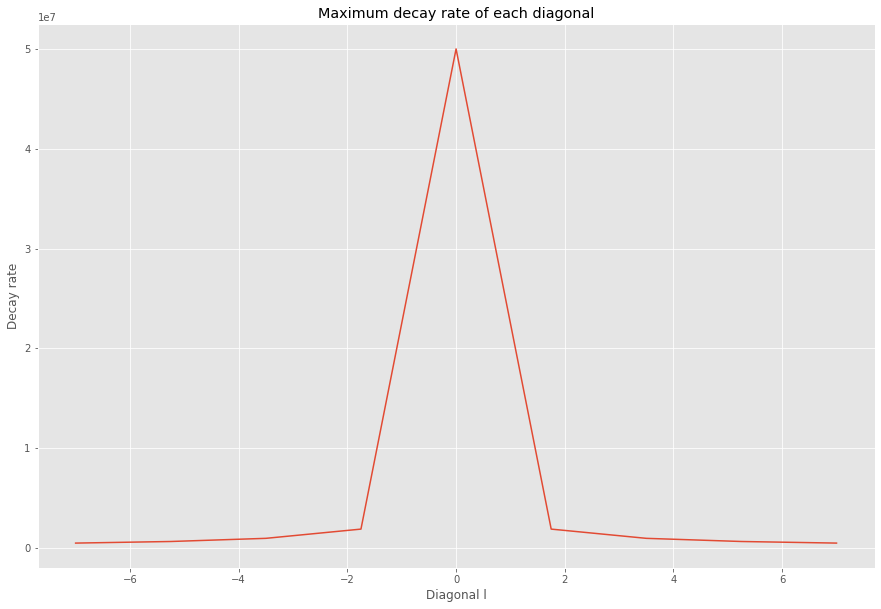

In [16]:
plt.figure(figsize=(15,10))
plt.title('Maximum decay rate of each diagonal')
plt.xlabel('Diagonal l')
plt.ylabel('Decay rate')
plt.plot(np.linspace(-7,7,2*N-1), [-np.min(1/d) for d in decays]);

In [24]:
np.min(1/decays[N-1])

-50000000.0

In [25]:
5e7

50000000.0

In [26]:
5e7

50000000.0